# Model-Predictive Path Integral Control Example

In [1]:
%load_ext autoreload
%autoreload 2

## Imports and Parameters

In [48]:
import time
from utils import * # imports integrators and other useful things
from system import * # imports system dynamics and objective
from MPPI import MPPI # imports controller
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

###################
# System parameters
# x0 = np.array([0,0])
# x0 = np.array([0,0,np.pi/3.0])
# x0 = np.array([0,0,0,0])
x0 = np.array([0,0])
del_t = 0.05 # 0.05 was good for diff, 0.2 for others
w_sz = 15
ov = 1
# dyn = lambda x, u: single_int(x,u) 
# dyn = lambda x, u: double_int(x,u) 
# dyn = lambda x, u: diff_drive(x,u) 
dyn = lambda x, u: double_int_1D(x,u) 

######################
# Objective parameters
# R = 0.1*np.diag([1.0,1.0])
R = 0.1*np.diag([1.0])
# R = None
# Q = np.diag([1,1])
# Q = np.diag([1,1,.01])
# xd = np.array([5,2])
# xd = np.array([5.,2.,0.])
# u0 = np.array([0.1, 0.1])
u0 = np.array([0.0])
# mean1 = np.array([-1.5,-1.5])
# mean2 = np.array([1.5, 1.5])
# cov1 = 1.*np.diag([1, 1])
# cov2 = 1.*np.diag([1, 1])
# w1 = 20.0 # weight given to tracking objective, 20 worked for single int, 1 worked for diff
# w2 = -5.0 # weight given to rattling objective, -5 worked for single int, -70 worked for diff 
xloc = 0.1; a = 0.5; b = 3.0;
w = -100; # 1D potential well params
# obj = lambda x, u: quadratic_objective(x,u,xd,Q,R)
# obj = lambda x, u: quadratic_rattling_objective(x, u, del_t, w1, w2, None, w_sz, ov, xd, Q, R)
# obj = lambda x, u: bimodal_rattling_objective(x[:2,:], u, mean1, cov1, mean2, cov2, del_t, w1, w2, w_sz, ov, R)
# obj = lambda x, u: bimodal_rattling_objective(x, u, mean1, cov1, mean2, cov2, del_t, w1, w2, w_sz, ov, R)
obj = lambda x, u: double_well_rattling_objective_1D(x, u, a, b, xloc, del_t, w, w_sz, ov, R)

#######################
# Controller parameters
noise_mean = np.array([0.0])
# noise_mean = np.array([0.0, 0.0])
# noise_var = 5.0*np.diag([1.0, 1.0]) # 5 worked for diff, 2 for others
noise_var = 1.0*np.diag([1.0])
samp_num = 40 # 100 was good for diff
predictive_horizon = 30 # 100 was good for diff
simulation_length = 400 # 1000 was good for diff
Temp = 1.0

## Initialize Controller

In [40]:
controller = MPPI(dyn, obj, x0, u0, K=samp_num, N=predictive_horizon, dt=del_t, lamb=Temp, noise_mu=noise_mean, noise_sigma=noise_var)

## Main Loop

In [41]:
tic = time.time()
xlist = []
ulist = []
costlist = []
for i in range(simulation_length):
    u_star = controller.step(x0)[:,0]
#     u_star = np.random.multivariate_normal(noise_mean, noise_var)
    x = integrate(dyn,x0,u_star,del_t)
    x0 = np.copy(x)
    xlist.append(x0)
    ulist.append(u_star)
    costlist.append(np.mean(controller.cost_total))
    if (i+1) % int(simulation_length/4.0) == 0:
        print(str(int(100.0*((float(i+1)/float(simulation_length)))))+"% complete. Time elapsed: "+str(np.round(time.time()-tic,2))+"s.")
xtraj = np.array(xlist).T
utraj = np.array(ulist).T

25% complete. Time elapsed: 7.1s.
50% complete. Time elapsed: 14.67s.
75% complete. Time elapsed: 22.06s.
100% complete. Time elapsed: 29.37s.


## Plot

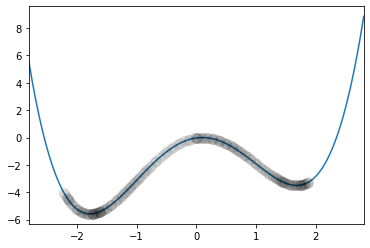

In [49]:
fun = lambda x: double_well_1D(x, a, b, xloc)
xv = np.linspace(-2.8,2.8,100)
yv = np.array([fun([x]) for x in xv])
pot_traj = np.array([fun([x]) for x in xtraj[0]])
plt.figure()
plt.plot(xv,yv,zorder=0)
skip = 1
plt.scatter(xtraj[0,::skip],pot_traj[::skip],c='k',alpha=0.03,zorder=1,s=100)
plt.xlim([-2.8,2.8])
# plt.ylim([-2.8,5])
plt.show()

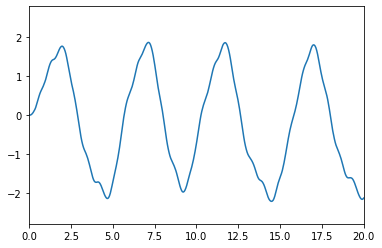

In [50]:
tvec = np.linspace(0,del_t*xtraj.shape[1],xtraj.shape[1])
plt.figure()
plt.plot(tvec,xtraj[0])
plt.ylim([-2.8,2.8])
plt.xlim([tvec[0],tvec[-1]])
plt.show()

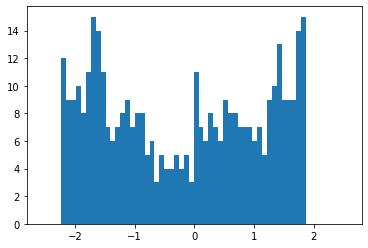

In [51]:
plt.figure()
plt.hist(xtraj[0],bins=50)
plt.xlim([-2.8,2.8])
plt.show()

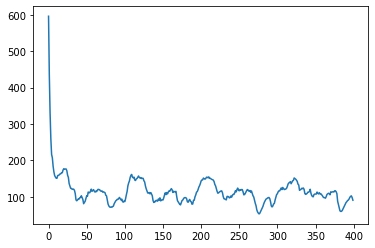

In [52]:
plt.figure()
plt.plot(costlist)
plt.show()

In [ ]:
# plt.close('all')